# 5.8 网络中的网络
前几节介绍的LeNet、AlexNet和VGG在设计上的共同之处是：先以由卷积层构成的模块充分抽取空间特征，再以由全连接层构成的模块来输出分类结果。其中，AlexNet和VGG对LeNet的改进主要在于如何对这两个模块加宽（增加通道数）和加深。本节我们介绍网络中的网络（NiN）[1]。它提出了另外一个思路，即串联多个由卷积层和“全连接”层构成的小网络来构建一个深层网络。

## 5.8.1 NiN块
我们知道，卷积层的输入和输出通常是四维数组（样本，通道，高，宽），而全连接层的输入和输出则通常是二维数组（样本，特征）。如果想在全连接层后再接上卷积层，则需要将全连接层的输出变换为四维。回忆在5.3节（多输入通道和多输出通道）里介绍的$1×1$卷积层。它可以看成全连接层，其中空间维度（高和宽）上的每个元素相当于样本，通道相当于特征。因此，NiN使用$1×1$卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。图5.7对比了NiN同AlexNet和VGG等网络在结构上的主要区别。

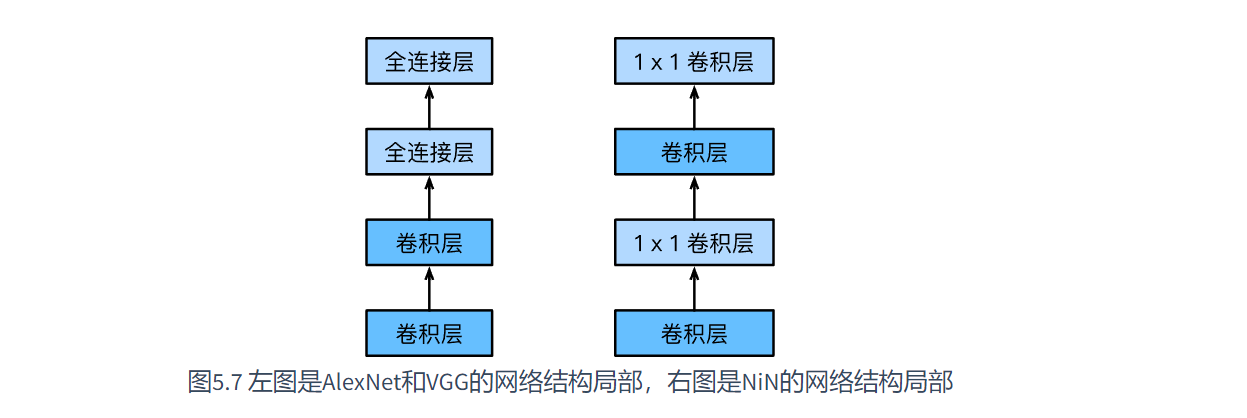

NiN块是NiN中的基础块。它由一个卷积层加两个充当全连接层的$1×1$卷积层串联而成。其中第一个卷积层的超参数可以自行设置，而第二和第三个卷积层的超参数一般是固定的。

In [2]:
import time
import torch
from torch import nn, optim

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    blk = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size=1),
                        nn.ReLU())
    return blk

## 5.8.2 NiN模型
NiN是在AlexNet问世不久后提出的。它们的卷积层设定有类似之处。NiN使用卷积窗口形状分别为$11×11$、$5×5$和$3×3$的卷积层，相应的输出通道数也与AlexNet中的一致。每个NiN块后接一个步幅为2、窗口形状为$3×3$的最大池化层。

除使用NiN块以外，NiN还有一个设计与AlexNet显著不同：NiN去掉了AlexNet最后的3个全连接层，取而代之地，NiN使用了输出通道数等于标签类别数的NiN块，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。这里的全局平均池化层即窗口形状等于输入空间维形状的平均池化层。NiN的这个设计的好处是可以显著减小模型参数尺寸，从而缓解过拟合。然而，该设计有时会造成获得有效模型的训练时间的增加。

In [3]:
# 已保存在d2lzh_pytorch
import torch.nn.functional as F
class GlobalAvgPool2d(nn.Module):
    # 全局平均池化层可通过将池化窗口形状设置成输入的高和宽实现
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])
    
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    GlobalAvgPool2d(),
    # 将四维的输出转成二维的输出，其形状为（批量大小，10）
    d2l.FlattenLayer()
)

我们构建一个数据样本来查看每一层的输出形状。

In [4]:
X = torch.rand(1, 1, 224, 224)
for name, blk in net.named_children():
    X = blk(X)
    print(name, 'output shape: ', X.shape)

0 output shape:  torch.Size([1, 96, 54, 54])
1 output shape:  torch.Size([1, 96, 26, 26])
2 output shape:  torch.Size([1, 256, 26, 26])
3 output shape:  torch.Size([1, 256, 12, 12])
4 output shape:  torch.Size([1, 384, 12, 12])
5 output shape:  torch.Size([1, 384, 5, 5])
6 output shape:  torch.Size([1, 384, 5, 5])
7 output shape:  torch.Size([1, 10, 5, 5])
8 output shape:  torch.Size([1, 10, 1, 1])
9 output shape:  torch.Size([1, 10])


## 5.8.3 获取数据和训练模型
我们依然使用Fashion-MNIST数据集来训练模型。NiN的训练与AlexNet和VGG的类似，但这里使用的学习率更大。

In [6]:
# batch_size = 128
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# lr, num_epochs = 0.002, 5
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda  
epoch 1, loss 1.8599, train acc 0.383, test acc 0.518, time 166.3 sec  
epoch 2, loss 1.3870, train acc 0.526, test acc 0.542, time 167.4 sec  
epoch 3, loss 1.2742, train acc 0.542, test acc 0.528, time 167.6 sec  
epoch 4, loss 1.2117, train acc 0.569, test acc 0.583, time 167.6 sec  
epoch 5, loss 1.1716, train acc 0.584, test acc 0.586, time 167.8 sec

# 小结
* NiN重复使用由卷积层和代替全连接层的$1×1$卷积层构成的NiN块来构建深层网络。
* NiN去除了容易造成过拟合的全连接输出层，而是将其替换成输出通道数等于标签类别数的NiN块和全局平均池化层。
* NiN的以上设计思想影响了后面一系列卷积神经网络的设计。